In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
import time
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
def construct_damped_periodic_kernel(params):
    kernel = params[0] * RBF(length_scale=params[1]) * ExpSineSquared(length_scale=params[2], periodicity=params[3])
    return kernel

def simulate(n, true_params, initial_params, eps, num_restarts = 1):
    x = np.linspace(start = 0, stop = 1, num = n).reshape(-1, 1)
    shift = np.random.uniform(-1 / (4 * n), 1 / (4 * n), size=n).reshape(-1, 1)
    x = x + shift
    true_kernel = construct_damped_periodic_kernel(true_params) + WhiteKernel(noise_level=eps)
    true_gp = GaussianProcessRegressor(kernel=true_kernel, alpha=0)
    y = np.squeeze(true_gp.sample_y(x, random_state=None))
    #plt.plot(x, y)
    
    kernel = construct_damped_periodic_kernel(initial_params)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=num_restarts, alpha=eps)
    gp.fit(x, y)
    
    gp_params = gp.kernel_.get_params()
    numerical_params = [value for key, value in gp_params.items() if isinstance(value, (int, float, np.float64))]
    return numerical_params

n = 500
true_params = [1, 1/200, 1/100, 2]
initial_params = [1.1 * p for p in true_params]
eps = 0.1
simulate(n, true_params, initial_params, eps, 0)
    

[1.0163687108489836,
 0.005197226020399493,
 0.009997173928961626,
 1.9548460785649173]

In [3]:
# Function to generate plots
def get_param_estimates(sample_sizes, true_params, initial_params, eps, num_restarts, num_replicates):
    # Collect estimates
    estimates = []
    for n in sample_sizes:
        estimates.append([simulate(n, true_params, initial_params, eps, num_restarts) for _ in range(num_replicates)])
    
    param_estimates = [[[est[i] for est in sample] for sample in estimates] for i in range(len(true_params))]
    flattened_estimates = np.array(param_estimates).reshape(len(true_params), -1)  # Flatten the nested list
    np.savetxt('./results/damped-periodic-simulation.txt', flattened_estimates)
    return param_estimates
    
def generate_boxplots(param_estimates, true_params, sample_sizes, param_names):
    # Create boxplots
    fig, axs = plt.subplots(1, len(true_params), figsize=(24, 6))
    for i, param_estimate in enumerate(param_estimates):
        axs[i].boxplot(param_estimate, labels=sample_sizes, vert=True)
        axs[i].axhline(y=true_params[i], color='r', alpha=0.5, linestyle='--')
        axs[i].set_xticks(range(1, len(sample_sizes) + 1))
        axs[i].set_xlabel('Sample Size', fontsize=15)
        axs[i].set_title(f'{param_names[i]}', fontsize=20)

    plt.tight_layout()
    plt.savefig('./boxplots/damped-periodic-simulation.png')
    plt.show()

# Timing execution
start_time = time.time()

# Parameters
num_replicates = 100
true_params = [1, 1/200, 1/100, 4]
initial_params = [1 * p for p in true_params]
eps = 0.1
num_restarts = 0
sample_sizes = [50, 100, 200, 500]  # Example sample sizes

np.random.seed(2024)
param_estimates = get_param_estimates(sample_sizes, true_params, initial_params, eps, num_restarts, num_replicates)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


Execution time: 318.01378202438354 seconds


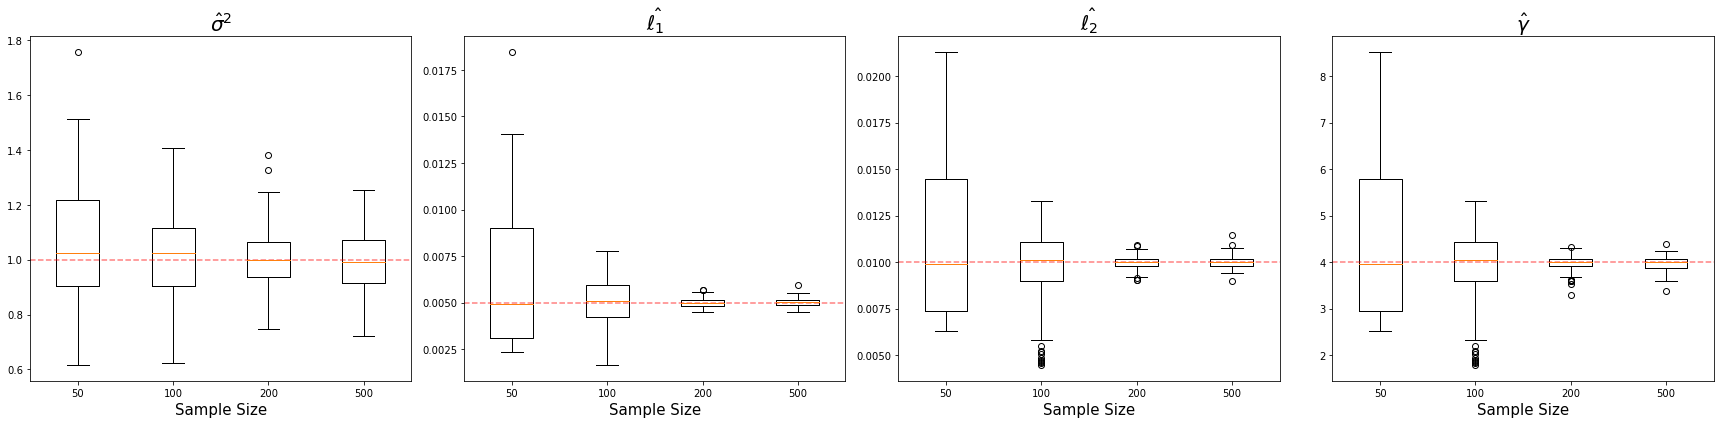

In [4]:
flattened_estimates = np.loadtxt('./results/damped-periodic-simulation.txt')
param_estimates = flattened_estimates.reshape(len(true_params), len(sample_sizes), num_replicates).tolist()
param_names = [r'$\hat{\sigma}^2$', r'$\hat{\ell_1}$', r'$\hat{\ell_2}$', r'$\hat{\gamma}$']
generate_boxplots(param_estimates, true_params, sample_sizes, param_names)

In [5]:
def check(n, params):
        kernel = construct_damped_periodic_kernel(params)
        print(kernel)
        x = np.linspace(0, 1, n)
        K = kernel([[p] for p in x])
        eigvals = np.sort(np.linalg.eigvals(K))
        print(np.linalg.cond(K))
        print(eigvals)
    
n = 500
 #[2.6 ** 2, 2, 1.5, 1 / 45]
params =  [1, 1/200, 1/100, 4]
check(n, params)

1**2 * RBF(length_scale=0.005) * ExpSineSquared(length_scale=0.01, periodicity=4)
88859919.39773959
[5.53461941e-08 5.58310050e-08 5.66417824e-08 5.77826775e-08
 5.92595275e-08 6.10798803e-08 6.32530278e-08 6.57900451e-08
 6.87038397e-08 7.20092055e-08 7.57228881e-08 7.98636553e-08
 8.44523785e-08 8.95121216e-08 9.50682391e-08 1.01148485e-07
 1.07783129e-07 1.15005085e-07 1.22850051e-07 1.31356659e-07
 1.40566632e-07 1.50524967e-07 1.61280113e-07 1.72884176e-07
 1.85393132e-07 1.98867059e-07 2.13370378e-07 2.28972119e-07
 2.45746197e-07 2.63771711e-07 2.83133260e-07 3.03921282e-07
 3.26232410e-07 3.50169854e-07 3.75843806e-07 4.03371870e-07
 4.32879520e-07 4.64500581e-07 4.98377743e-07 5.34663112e-07
 5.73518778e-07 6.15117434e-07 6.59643021e-07 7.07291414e-07
 7.58271152e-07 8.12804203e-07 8.71126783e-07 9.33490211e-07
 1.00016182e-06 1.07142594e-06 1.14758488e-06 1.22896004e-06
 1.31589302e-06 1.40874683e-06 1.50790718e-06 1.61378380e-06
 1.72681185e-06 1.84745342e-06 1.97619913e-06 